**Họ và tên: Nguyễn Quốc An**  
**MSSV: 18020106**  
**Lớp: K63CACLC2**  

**Vấn đề** có thể giúp ích được gì   
**Giải phasp** vẽ biểu đồ để rút ra nhận xét hoặc tạo feature mới hoặc clean data  
**Nhận xest** kết quả ntn, đã ổn chưa, chưa ổn ở chỗ nào =>> Hướng xử lí  
**Hướng xử lí**  

In [652]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from tqdm import tqdm
import os
from IPython import display

# **1. Tổng quan bài toán** 

## 1. 1 Bài toán:

Dự đoán khoảng thời gian còn lại cho đến khi xảy ra động đất tiếp theo dựa vào dữ liệu đia chấn đã ghi nhận được. Đây là động đất được tạo ra trong phòng thí nghiệm, mô tả một trận động đất thông thường  
**Vấn đề cần giải quyết:** https://www.kaggle.com/c/LANL-Earthquake-Prediction  
**Phân loại vấn đề:** Trong học máy, bài toán này thuộc nhóm bài toán hồi quy. 

## 1.2 Tổng quan về dữ liệu

**Mục đích** của tổng qua dữ liệu là xem các đặc điểm của dữ liệu về độ lớn của tập dữ liệu, số trường dữ liệu, kiểu dữ liệu tại mỗi trường để có các phương pháp triển khai hợp lí.  

### 1.2.1 Dữ liệu huấn luyện

**Công việc:** <br>
- Mô tả độ lớn của file chứa dữ liệu
- Mô tả số số hàng: Do không thể tải toàn bộ file nên số liệu được tham khảo trên kaggle
- Mô tả các trường dữ lệu 
- Mô tả kiểu dữ liệu của từng trường 

In [2]:
print("Độ lớn của file train chứa dữ liệu:",Path('data/train.csv').stat().st_size, "bytes", '\n')
train = pd.read_csv('data/train.csv', nrows=6000000)
print("In ra 5 dòng đầu tiên trong dữ liệu:")
print(train[:5], '\n')
print("Số hàng: 629000000 điểm dữ liệu", '\n')
print("In ra ra kiểu dữ liệu của từng trường:")
train.info()

Độ lớn của file train chứa dữ liệu: 9555558244 bytes 

In ra 5 dòng đầu tiên trong dữ liệu:
   acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691 

Số hàng: 629000000 điểm dữ liệu 

In ra ra kiểu dữ liệu của từng trường:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 91.6 MB


**Bình luận:** 
- **Độ lớn của tập huấn luyện:** Đối với em, đây là một bộ dữ liệu lớn gây ra rất nhiều khó khăn trong điều kiện thiết bị không thể tải được toàn bộ dữ liệu vào. Em đã tìm hiểu khác nhau để tải và xử dụng dữ liệu:
    - **Cách 1: Dùng google colab để móc dữ liệu về qua Kaggle API:**
            - Ưu điểm: Tốc độ Download nhanh. Xử dụng được colab với sự hỗ trợ của GPU.
            - Nhược điểm: Dữ liệu lưu tạm thời trên máy ảo. Mỗi lần tải lại lại mất.
    - **Cách 2: Dùng jupyter notebook ở local:**
            - Ưu điểm: Có thể train khi không có mạng. Không phải tải lại bộ dữ liệu.
            - Nhược điểm: Không có GPU. Không thể đọc một lúc toàn bộ file train  
- **Các trường dữ liệu:**: Dữ liệu có dạng timeseries nên chỉ gồm 2 cột là acousstic_data là tín hiệu và time_to_failure là thời gian còn lại từ tín hiệu đó cho đến trận động đất tiếp theo. 
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** có trường `int64` lớn có thể hạ xuống `int16` để giảm bộ nhớ. **time_to_failure** cũng có trường `float64`, tuy nhiên thời gian cần được biểu diễn chính xác nên không hạ xuống trường thấp hơn. <br>


**Hướng xử lí**
- **Độ lớn của tập huấn luyện:** Sau quá trình cân nhắc, em đã lựa chọn ***cách 2*** cùng với chiến lược khắc phục nhược điểm bằng cách **khi visualization** chỉ sử dụng một phần tập train. **Khi trích chọn đặc trưng** thì dùng cửa sổ trượt để đọc từng segment một.   
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** hạ xuống `int16` để giảm bộ nhớ. 

### 1.2.2 Dữ liệu kiểm tra

Mục đích được trình bày ở phía trên.
Do các dữ liệu kiểm tra được chia ra thành các segment. Mỗi segment chứa trong 1 file nên phần công việc hơi khác một chút gồm có:
- Mô tả số lượng segment trong thư mục test
- Mô tả độ lớn trung bình của file chứa dữ liệu
- Mô tả các trường dữ lệu
- Mô tả kiểu dữ liệu của từng trường

In [3]:
path, dirs, files = next(os.walk("data/test"))
file_count = len(files)
print('Số segment trong thư mục test là', file_count, '\n')

file_size = 0
for file in files:
    file_size += Path("data/test/" + file).stat().st_size
file_size = file_size/file_count 
print("Kích thước trung bình của một segment là", file_size, "bytes",'\n')

test1 = pd.read_csv('data/test/seg_00030f.csv') 
print("In ra 5 dòng đầu tiên trong dữ liệu:")
print(test1[:5], '\n')

print("Số điểm dữ liệu trong 1 segment:", len(test1), '\n')

print('Kiểu dữ liệu của trường acousstic_data')
test1.info()

Số segment trong thư mục test là 2624 

Kích thước trung bình của một segment là 329204.140625 bytes 

In ra 5 dòng đầu tiên trong dữ liệu:
   acoustic_data
0              4
1              0
2             -2
3              0
4              2 

Số điểm dữ liệu trong 1 segment: 150000 

Kiểu dữ liệu của trường acousstic_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   acoustic_data  150000 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


**Bình luận và xử lí:** 
- **Số lượng segment** là 2624 tương ứng với 2624 file test 
- **Độ lớn của tập huấn luyện:** Do dữ liệu test nhỏ vì đã được chia thành các segment nên độ lớn file nhỏ không đáng lo ngại trong quá trình xử lí 
- **Các trường dữ liệu:**: Dữ liệu có 1 cột là acousstic_data là tín hiệu ghi nhận được 
- **Kiểu dữ liệu cả các trường:** Dữ liệu **acoustic_data** có trường `int64` lớn được hạ xuống `int16`tương tự tập huấn luyện

# 2 Tiền xử lí dữ liệu

**Vấn đề:**
- Tiền xử lí dữ liệu có hai nhiệm vụ là xử lí các điểm dữ liệu bất thường và trích chọn đặc trưng cho bài toán
- Trong tiền xử lí, trực quan hóa dữ liệu đóng vai trò quan trọng giúp người dùng hiểu bài toán, hiểu đặc điểm dữ liệu từ dó đưa ra các bước xử lí dữ liệu và các bước trích chọn đặc trưng sao cho phù hợp.

**Công việc:** 
- Kiểm tra null
- Xử lí nhiễu 
- Trích chọn đặc trưng

## 2.1 Kiểm tra null 

**Vấn đề:** Dữ liệu null ảnh hướng lớn tới các mô hình học, có thể gây ra lỗi. Việc xử lí dữ liệu null có thể giúp mô hình học máy học tốt hơn  
**Công việc:** Kiểm tra null cho từng segment có độ dài 60.000.000 điểm dữ liệu 

In [4]:
rows = 60000000
segments = int(600000000/rows)

In [5]:
has_null = False 
for segment in tqdm(range(segments)): 
    data = pd.read_csv('data/train.csv', nrows = rows, skiprows=segment*rows+1)
    if True in data.isnull(): has_null = True 
    del data 
print(has_null)

100%|██████████| 10/10 [04:25<00:00, 26.57s/it]

False


**Bình luận:** Thật may mắn, dữ liệu không có null 

## 2.2 Khử nhiễu 

**Vấn đề**: Dù thí nghiệm được thực hiện trong phòng thí nghiệm, nhưng khi các thiết bị vật lí hoạt động không thể không tránh được nhiễu.  
**Giải pháp:** Trực quan hóa một phần dữ liệu để quan sát, xác định nhiễu. 

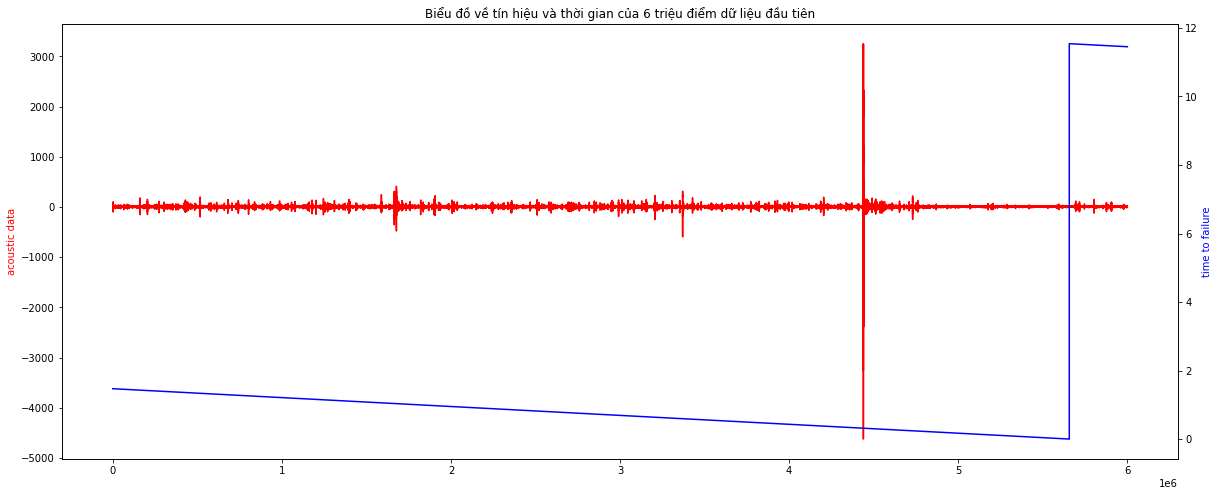

In [6]:
train_samples = pd.read_csv('data/train.csv', nrows=6000000)
fig, ax1 = plt.subplots(figsize=(20, 8))
plt.plot(train_samples.acoustic_data,color='r')
ax1.set_ylabel('acoustic data',color='r')

ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='b')
plt.plot(train_samples.time_to_failure,color='b')

plt.title('Biểu đồ về tín hiệu và thời gian của 6 triệu điểm dữ liệu đầu tiên')
plt.show()

**Bình luận:** Việc trực quan hóa dữ liệu ở dạng time domain khá là khó để xác định nhiễu với một người không có kiến thức chuyên ngành về động đất như em. Có một vùng tín hiệu giao động mạnh nhưng có thể là dấu hiệu của một trận động đất chứ không phải một nhiễu.  
**Hướng giải quyết:** Chuyển trường dữ liệu từ thời gian qua miền tần số bằng cách dùng FFT   
**Công việc tiếp theo:** Chuyển dữ liệu qua miền tần số và trực quạn hóa tần số bằng cách sử dụng số phức 

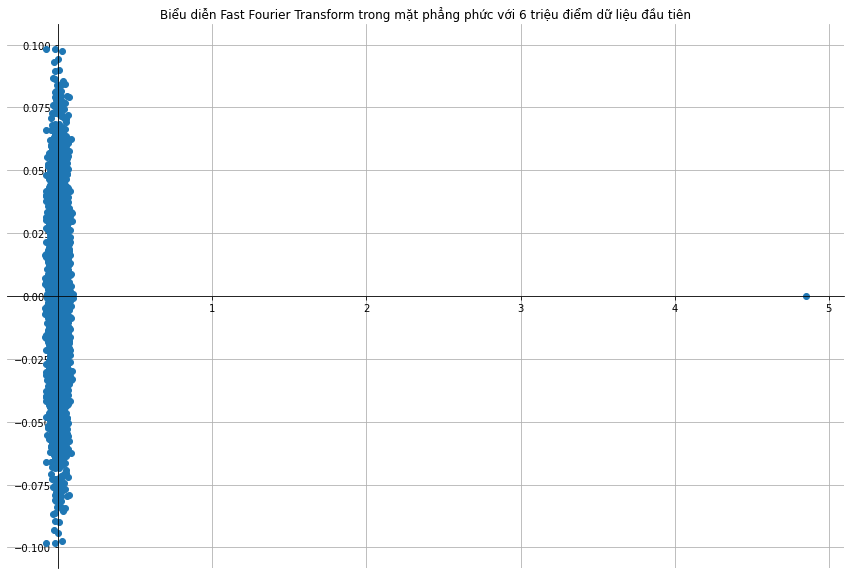

In [97]:
train_samples = pd.read_csv('data/train.csv', nrows=600000)
zc = np.fft.fft(train_samples.acoustic_data.values)/len(train_samples.acoustic_data.values)
realFFT = np.real(zc)
imagFFT = np.imag(zc)

fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True, which='both')
ax.plot(realFFT, imagFFT, 'o')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.title('Biểu diễn Fast Fourier Transform trong mặt phẳng phức với 6 triệu điểm dữ liệu đầu tiên')
plt.show()

**Bình luận:** Có một điểm nằm xa so với vùng tập trung nên có thể là điểm nhiễu.  
**Hướng xử lí:** Gán các điểm nhiễu bằng độ lớn trung bình của toàn bộ segment 

In [8]:
for index in range(len(realFFT)):
    a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
    if a>0.1:
        realFFT[index] = np.mean(realFFT)
        imagFFT[index] = np.mean(imagFFT) 

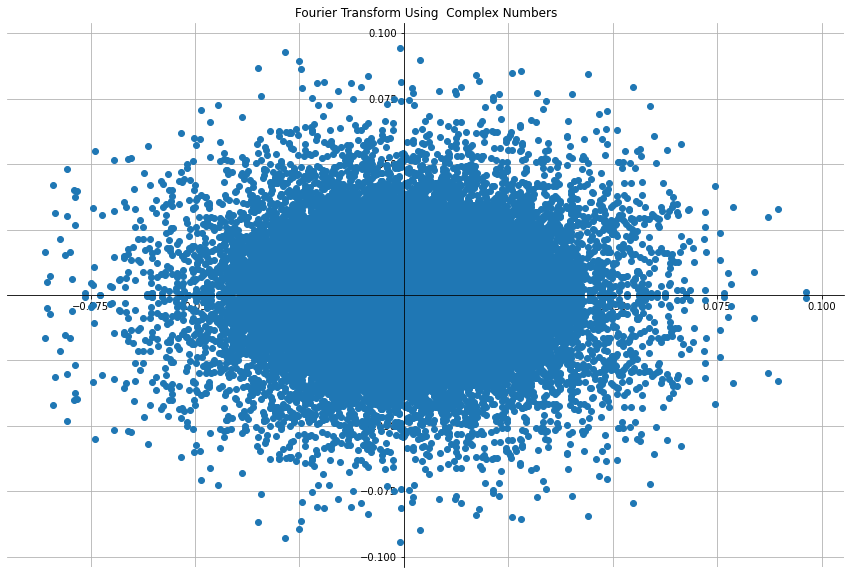

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.grid(True, which='both')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.title('Fourier Transform Using  Complex Numbers')
ax.plot(realFFT, imagFFT, 'o')
plt.show()

**Bình luận:** Hướng xử lí này hợp lí trên 6 triệu dữ liệu đầu tiên    
**Công việc tiếp theo:** Ta thử trên một tập dữ liệu rộng hơn để có kết quả khách quan 

  0%|          | 0/5 [00:00<?, ?it/s]

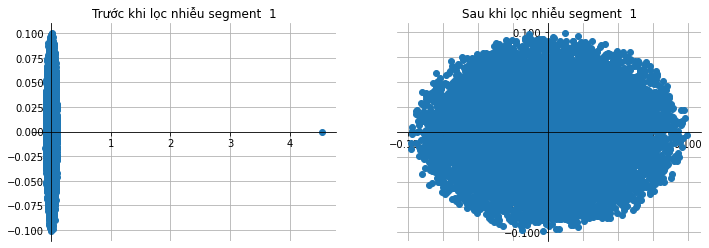

 20%|██        | 1/5 [00:14<00:59, 14.97s/it]

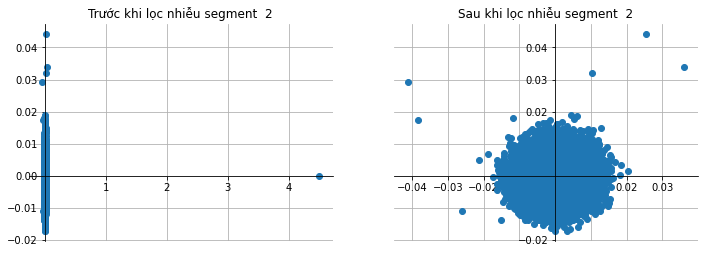

 40%|████      | 2/5 [00:29<00:44, 14.83s/it]

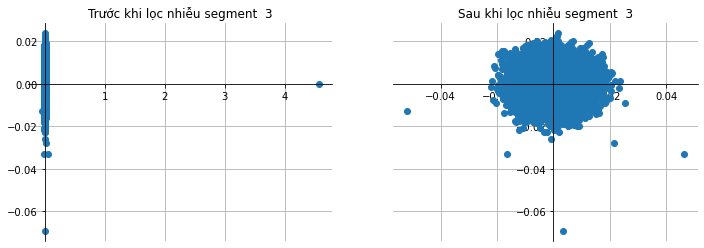

 60%|██████    | 3/5 [00:44<00:29, 14.83s/it]

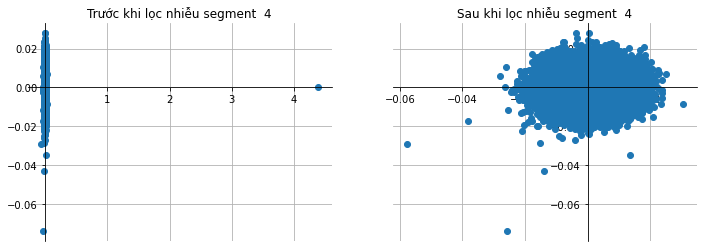

 80%|████████  | 4/5 [00:59<00:14, 14.82s/it]

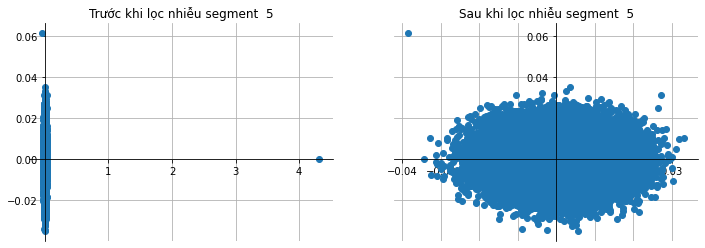

100%|██████████| 5/5 [01:14<00:00, 14.80s/it]


In [10]:
data = pd.read_csv('data/train.csv', nrows=30000000)
rows = 6000000
segments = int(30000000/rows)


for segment in tqdm(range(segments)):
    train_samples = data.acoustic_data.values[segment*rows : (segment+1)*rows]
    zc = np.fft.rfft(train_samples)/len(train_samples)
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 4))
    ax1.grid(True, which='both')
    ax1.spines['left'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['top'].set_color('none')
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    ax1.plot(realFFT, imagFFT, 'o')
    ax1.set_title('Trước khi lọc nhiễu segment  ' + str(segment+1))
    
    ax2.grid(True, which='both')
    ax2.spines['left'].set_position('zero')
    ax2.spines['right'].set_color('none')
    ax2.spines['bottom'].set_position('zero')
    ax2.spines['top'].set_color('none')
    for index in range(len(realFFT)):
        a = np.sqrt(realFFT[index] ** 2 + imagFFT[index]**2)
        if a>0.1:
            realFFT[index] = np.mean(realFFT)
            imagFFT[index] = np.mean(imagFFT) 
        
    ax2.plot(realFFT, imagFFT, 'o')
    ax2.set_title('Sau khi lọc nhiễu segment  ' + str(segment+1))
    plt.show()

**Bình luận:** Phương pháp lọc nhiễu trên có ích cho 3 triệu dữ liệu đầu tiên. Nên có thể sử dụng cho các dữ liệu sau này.  

**Công việc:** Ta định nghĩa hai hàm lọc nhiễu cho dữ liệu miền thời gian và miền tần số 

In [95]:
def denoise_for_fft(data, threshold, denoise=True):
    zc = np.fft.rfft(data)/len(data)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    
    if denoise:
        for index in range(len(realFFT)):
            if magFFT[index]>threshold:
                realFFT[index] = np.mean(realFFT)
                imagFFT[index] = np.mean(imagFFT) 

        magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)
    
    return realFFT,imagFFT, magFFT

**Bình luận:** Hàm `denoise_for_fft` hỗ trợ loại bỏ lỗi cho dữ liệu FFT và chuyển dữ liệu từ signal sang fft. Đầu vào có trường denoise:
- Nếu denoise = true sẽ tiến chuyển  đổi dữ liệu sang fft 
- Nếu denoise = false thì chỉ tiến hành chuyển đỗi dữ liệu sang fft

In [210]:
def denoise_for_signal(data, threshold):
    realFFT,imagFFT, magFFT = denoise_for_fft(data, threshold)
    
    return pd.DataFrame(np.fft.irfft(realFFT + 1j * imagFFT)*len(data))

**Bình luận:** Hàm `denoise_for_signal` hỗ trợ loại bỏ lỗi cho dữ liệu time domain bằng cách chuyển dữ liệu qua FFT, khử nhiễu cho FFT rồi chuyển ngược lại 

# 3 Phân tích sự tương đồng giữa dữ liệu train và dữ liệu test

**Vấn đề:**
- Phân tính sự tương đồng giữa dữ liệu train và dữ liệu test nhằm chắc chắn rằng dữ liệu chạy tốt trên tập validation thì sẽ chạy tốt trên tập test. 

**Công việc:** 
- Phân tích sự tương đồng thông qua phân bố của trường dữ liệu tín hiệu  

In [13]:
train_samples = pd.read_csv('data/train.csv', nrows=150000)
test1 = pd.read_csv('data/test/seg_00030f.csv') 
test2 = pd.read_csv('data/test/seg_1dec9c.csv') 
test3 = pd.read_csv('data/test/seg_5cfba9.csv') 

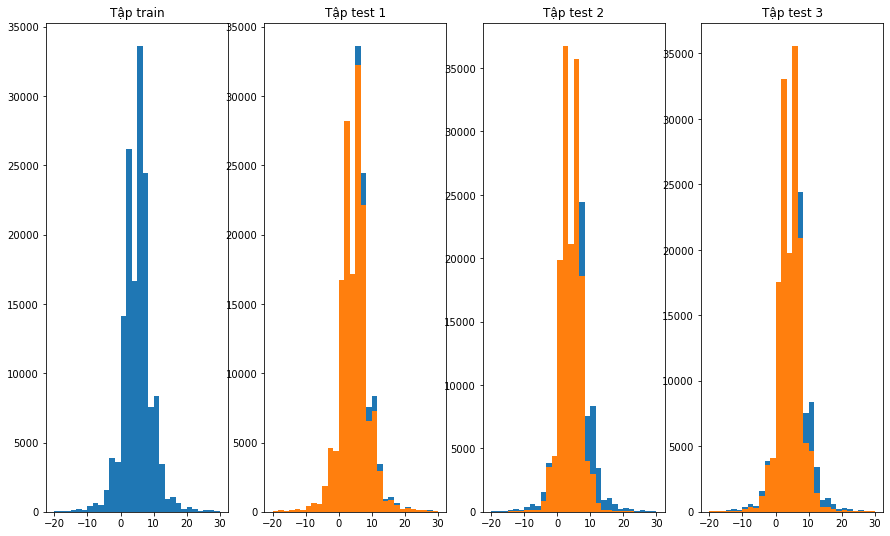

In [14]:
fig, (ax0, ax1, ax2,ax3) = plt.subplots(1, 4, figsize=(15,9))
ax0.set_title("Tập train")
ax1.set_title("Tập test 1")
ax2.set_title("Tập test 2")
ax3.set_title("Tập test 3")

ax0.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax1.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax2.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')
ax3.hist(train_samples['acoustic_data'], bins=30, range = [-20,30], align='mid')

ax1.hist(test1['acoustic_data'], bins=30, range = [-20, 30], align='mid')
ax2.hist(test2['acoustic_data'], bins=30, range = [-20, 30], align='mid')
ax3.hist(test3['acoustic_data'], bins=30, range = [-20, 30], align='mid')

plt.show()

**Bình luận:** Từ phân bố trên, ta có thể thấy rằng mức độ phân bố của tín hiệu tại các tập test và tập train là tương đương nhau.

# 4 Phân tích trích chọn đặc trưng 

**Vấn đề:**
- Đặc trưng của một bài toán học máy là một trong những yếu tố quyết định đến chất lượng và sự hiệu quả của mô hình.
- Do đó việc trích chọn đăc trưng cần được xem xét kĩ lưỡng và được phân tích rõ ràng nhờ và công cụ trực quan hóa dữ liệu 

**Công việc:** 
- Phân tích và trích chọn đặc trưng 

**Khó khăn**
- Vì dữ liệu tín hiệu hay timeseries có ít trường dữ liệu nên việc trực quan hóa khá khó khăn. Các đặc trưng và biểu đồ trực quan hóa bên dưới được em tham khảo một phần trong môn học Xử lí tiếng nói 

## 4.1 Phân tích mối quan hệ giữa hai trường dữ liệu 

In [296]:
train_samples = pd.read_csv('data/train.csv', nrows=60000000)

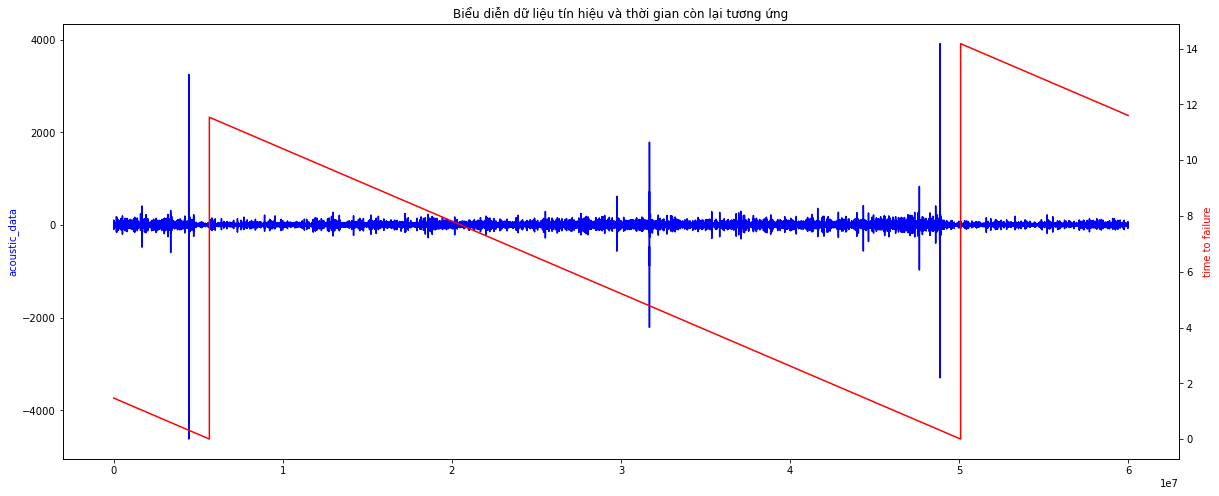

In [299]:
fig, ax1 = plt.subplots(figsize=(20, 8))

ax1.set_ylabel('acoustic_data', color='b')
plt.plot(train_samples.acoustic_data,color='b')

ax2=ax1.twinx()
ax2.set_ylabel('time to failure',color='r')
plt.plot(train_samples.time_to_failure,color='r')

plt.title('Biểu diễn dữ liệu tín hiệu và thời gian còn lại tương ứng')
plt.show()

**Bình luận:** 
- Mỗi khi động đất xảy ra thì giá trị time_to_failure giảm xuống xấp xỉ 0  
- Qua quan sát, em thấy rằng trước khi xảy ra động đất sẽ có 1 lần tín hiệu có biên độ lớn đột ngột  
- Em tiến hành phân tích các trường dữ liệu chi tiết hơn trong phần sau 

## 4.2 Phân tích các trường dữ liệu trong một chu kì động đất  

**Vấn đề:** Việc quan sát các trường dữ liệu biến đổi như thế nào trong một chu kì động đất sẽ biết được **xu hướng nào thì động đất dễ xảy ra, xu hướng nào thì động đất khó xảy ra**.     
**Công việc:**
- Tìm một chu kì động đất 
- Lần lượt phân tích hai trường thời gian và trường tín hiejeu

### 4.2.1 Tìm một chu kì động đất  

In [17]:
train_samples = pd.read_csv('data/train.csv', nrows=60000000)
train_samples['time_to_failure'].min()

0.00069548217471

**Bình luận:** 
- Theo biểu đồ trên, trong 60 triệu điểm dữ liệu đầu sẽ có 2 lần xảy ra động đất
- Tuy nhiên, giá trị thời gian nhỏ nhất khác 0 chứng tỏ rằng khi xảy ra động đất, giá trị thời gian chỉ xấp xỉ không. Việc này hoàn toàn dễ hiểu bởi tín hiệu ban đầu là tín hiệu liên tục nhưng đã trải qua quá trình lấy mẫu (sampling) sau đó.

**Hướng giải quyết:** Sử dụng hai giá trị nhỏ nhất làm điểm bắt đầu và điểm kết thúc của chu kì .

In [18]:
start = train_samples[0:10000000][['time_to_failure']].idxmin().values[0]
end = train_samples[10000000:60000000][['time_to_failure']].idxmin().values[0]
train_one_period = train_samples[start+1:end]

### 4.2.2 Trường thời gian còn lại 

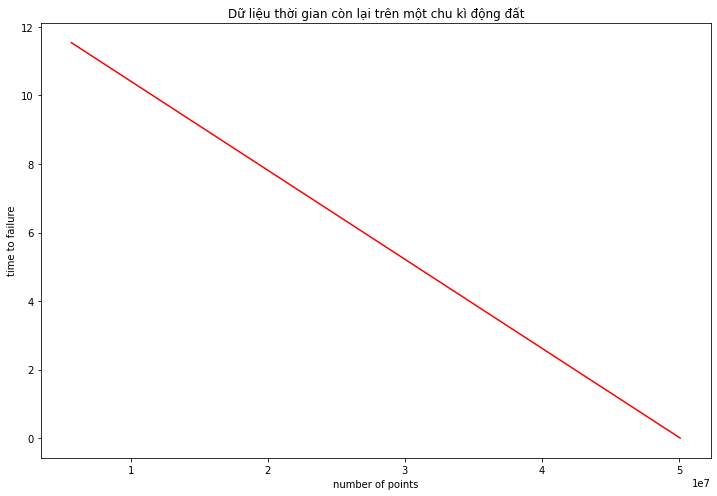

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure, color = 'r')
plt.title('Dữ liệu thời gian còn lại trên một chu kì động đất')
plt.xlabel('number of points')
plt.ylabel('time to failure')
plt.show()

**Bình luận:** Khi biểu diễn trên tập dữ liệu lớn, trường thời gian như đang giảm tuyến tính. Em tiến hành biểu diễn một đoạn dữ liệu nhỏ để xác minh điều này.

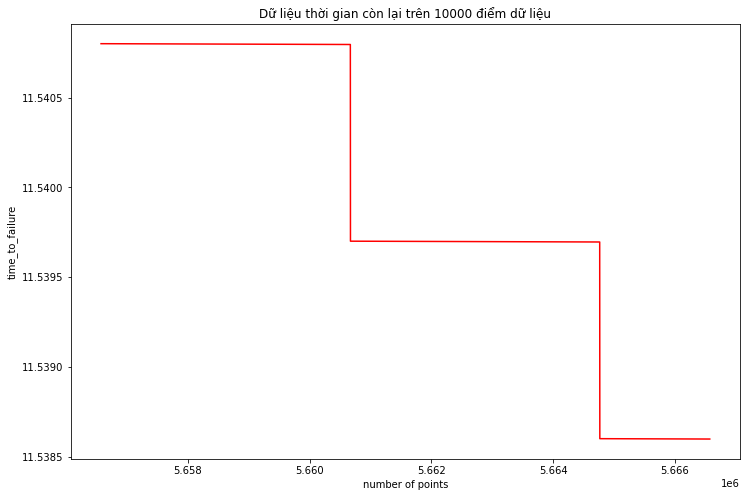

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure[:10000], color = 'r')
plt.title('Dữ liệu thời gian còn lại trên 10000 điểm dữ liệu')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.show()

**Bình luận** Trên 10000 điểm dữ liệu, dữ liệu giảm theo dạng bậc thang, tức là dữ liệu dảm nhẹ rồi giảm đột ngột sau mỗi ~4000 điểm dữ liệu. Điều này có tính chu kì vì đây là đặc điểm của thí nghiệm, 4096 điểm dữ liệu sẽ được ghi lần lượt. Sau đó, thiết bị sẽ dừng trong khoảng 12 ms trước khi tiếp tục ghi. Việc dừng lại tạo ra việc lỡ mất các điểm dữ liệu trong khoảng thời gian đó. 

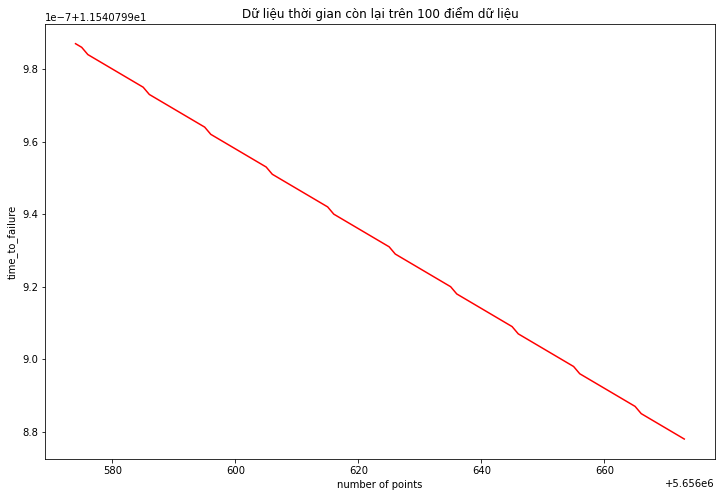

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.plot(train_one_period.time_to_failure[:100], color = 'r')
plt.title('Dữ liệu thời gian còn lại trên 100 điểm dữ liệu')
plt.xlabel('number of points')
plt.ylabel('time_to_failure')
plt.show()

**Bình luận** Xét trên 100 điểm dữ liệu, trong từng khoảng 4096 điểm dữ liệu, dữ liệu cũng không giảm tuyến tính mà là giảm gấp khúc có chu kì.  
**Kết luận** Việc áp dụng tính chất giảm tuyến tính kể cả trong từng 4096 dữ liệu hay trong toàn bộ dữ liệu là không hợp lí 

### 4.2.3 Trường tín hiệu 

**Bàn luận:** Do tập test cũng được chia thành các segment, nên việc trực quan hóa và phân tích trường tín hiệu cũng được thực hiện trên segment. 

**Công việc cụ thể:**
- B1: Chia dữ liệu của thành các segment
- B2: Thống kê đặc điểm, tính chất trên từng segment
- B3: Quan sát, bình luận sử biến đổi của các thống kê ấy khi thời gian cho lại cho đến khi xảy ra động đất dài, và khi thời gian còn lại cho đến khi xảy ra động đất ngắn.

**Lưu ý:** Tuy độ dài 1 segment của tập test là 150000, nhưng segment của tập train trong bước này chỉ để trực quan hóa nên sẽ thay đổi linh hoạt để đảm bảo tốc độ chạy chương trình.

#### 4.2.3.1  Thống kê về sự phân bố 

  0%|          | 0/5 [00:00<?, ?it/s]

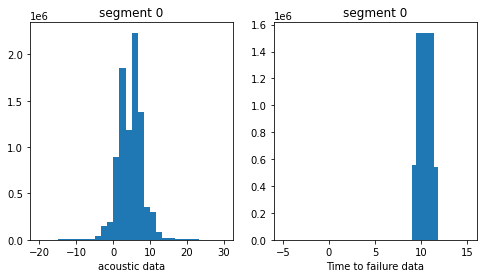

 20%|██        | 1/5 [00:00<00:02,  1.92it/s]

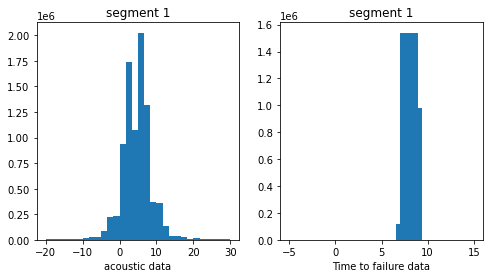

 40%|████      | 2/5 [00:01<00:01,  1.88it/s]

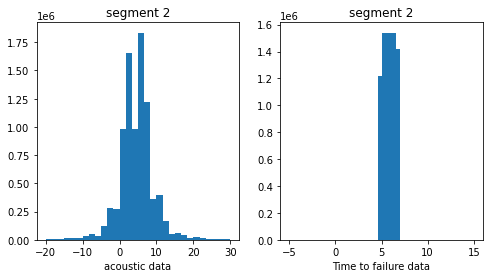

 60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

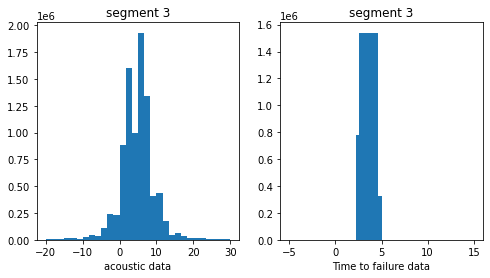

 80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

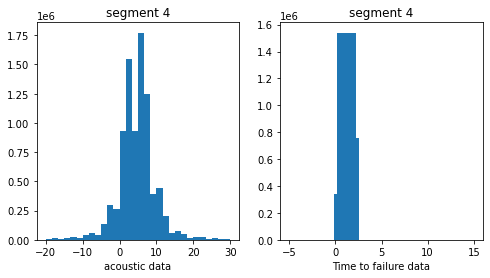

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


In [22]:
rows = 8800000
segments = int(len(train_one_period)/rows)


for segment in tqdm(range(segments)):
    train_samples = train_one_period[segment*rows : (segment+1)*rows]
            
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8, 4))
    ax1.hist(train_samples['acoustic_data'],bins=30, range = [-20,30], align='mid')
    ax1.set_title('segment '+ str(segment))
    ax1.set_xlabel('acoustic data')
    
    ax2.hist(train_samples['time_to_failure'], bins=50, range = [-5,15], align='mid')
    ax2.set_xlabel('Time to failure data')
    ax2.set_title('segment '+ str(segment))

    plt.show()
    del train_samples

**Bình luận:** Về hình dạng, hình dạng phân bố của các trường dữ liệu tại các segment khác nhau khá tương đồng, khi càng gần thời điển xảy ra động đất, hình dạng phân bố có hơi nhọn hơn một chút.

#### 4.2.3.2  Độ phủ biên độ (Amplitude Envelope) 

**Ý tưởng:** Như đã bình luận ở trên, khi sắp xảy ra động đất, tín hiệu của biên độ có một thời điểm tăng giảm đột ngột rất lớn. Vì vậy, xu hướng chung của biên độ có thể cũng có tính chất nào đó 

In [23]:
def get_envelope (input_signal, interval_length = 100000):    
    pos_signal = []
    neg_signal = []
    
    for segment in range (0, int(len(input_signal)/interval_length)):
        pos_signal.append(input_signal[segment*interval_length:(segment+1)*interval_length].max())
        neg_signal.append(input_signal[segment*interval_length:(segment+1)*interval_length].min())
        
    return pos_signal,neg_signal

**Bình luận:** 
- Hàm `get_envelope` thực hiện cộng việc:
    - Duyệt qua các segment 
    - Tìm giá trị lớn nhất và nhỏ nhất trong các segment đó
- Hàm `get_envelope` trả về độ bao phủ dương và độ bao phủ âm của tín hiệu đầu vào. Các tính là duyệt qua các segment rồi lấy giá trị lớn nhất và nhỏ nhấ tương ứng trong từng segment 

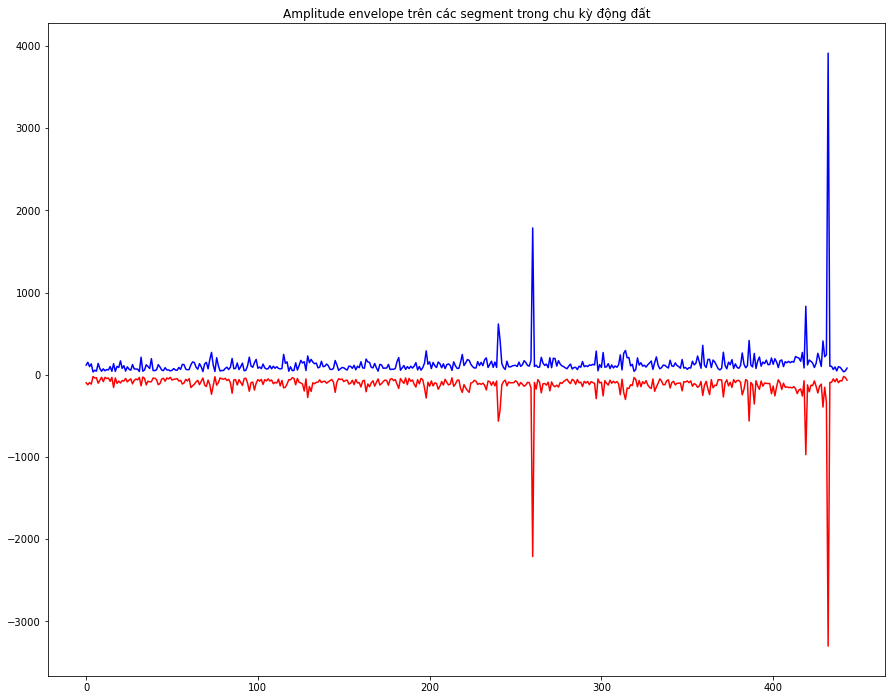

In [24]:
pos_amplitude_envelope, neg_amplitude_envelope = get_envelope(train_one_period['acoustic_data'])

fig, ax = plt.subplots(figsize=(15,12))
plt.plot(neg_amplitude_envelope, c="red")
plt.plot(pos_amplitude_envelope, c="blue")
plt.title("Amplitude envelope trên các segment trong chu kỳ động đất")

plt.show()

**Bình luận:** Theo chiều từ trái qua phải tương ứng với thời gian xảy ra động đất rút ngắn dần:
- Biên độ của tín hiệu có xu hướng tăng lên.
- Số lượng dao động đột biến (có độ lớn cao hơn hẳn các dao động xung quanh) cũng tăng lên.

#### 4.2.3.3 Độ lớn tín hiệu không đổi trong hai thời điểm liên tiếp  

**Ý tưởng:** Sự giao động bất ổn định phản ánh liên kết yếu kém của địa chất. Đây có thể là một trong những nhân tố báo hiệu một trận động đất sắp tới. Để hiểu rõ hơn sự biến động của dữ liệu, ta tiến hành khảo sát số lượng tín hiệu tại hai thời điền liên tiếp có giá trị bằng nhau. 

In [25]:
def get_number_signal_unchange(input_signal, interval_length = 500000):
    num = []
    for segment in range (0, int(len(input_signal)/interval_length)):
        s = 0
        for index in range(segment*interval_length+1,(segment+1)*interval_length):
            if (input_signal[index] - input_signal[index -1] == 0):
                s+=1
        num.append(s)
    return num

**Bình luận:** 
- Hàm `get_number_signal_unchange` thực hiện cộng việc:
    - Duyệt qua các segment 
    - Đếm số tín hiệu mà có độ lớn không đổi so với thời điểm trước đó
- Hàm `get_number_signal_unchange` trả về số lượng tín hiệu không đổi trong segment đó 

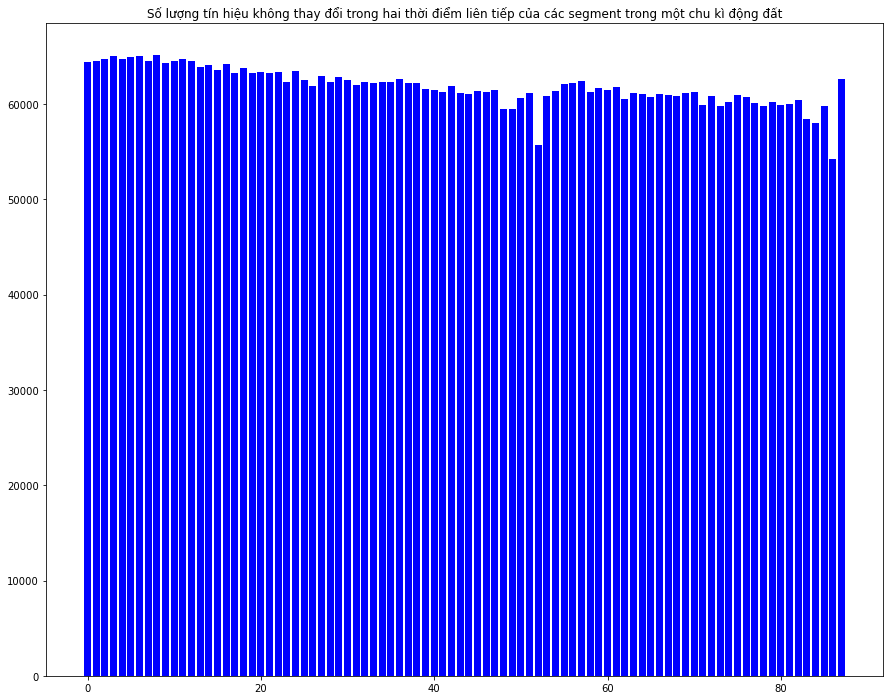

In [26]:
num = get_number_signal_unchange(train_one_period.acoustic_data.values)
fig, ax = plt.subplots(figsize=(15,12))
plt.bar(range(len(num)),num, color='blue')
plt.title("Số lượng tín hiệu không thay đổi trong hai thời điểm liên tiếp của các segment trong một chu kì động đất")
plt.show()

**Bình luận:** 
- Đồ thị giảm dần từ trái sáng phải theo chiều thời điện động đất xảy ra sắp đến gần thể hiện rằng càng gần thời điểm xảy ra động đất thì tín hiệu càng bất ổn 
- Do độ chênh giữa các segment trong 1 chu kì về số lượng tín hiệu không thay đổi này không nhiều nên khi trích chọn đặc trưng chỉ được sử dụng cho trích chọn đặc trưng toàn cục 

####  4.2.3.4 Số lần đổi dấu qua trục tọa độ (Zero-crossing rate)

**Ý tưởng:** Khảo sát thêm sự bất ổn định qua số lần đổi dấu qua trục toán độ với mỗi segment

In [27]:
def get_ZOR(input_signal, interval_length = 500000):
    ZOR = []
    for segment in range (0, int(len(input_signal)/interval_length)):
        s = 0
        for index in range(segment*interval_length+1,(segment+1)*interval_length):
            if (input_signal[index]*input_signal[index -1] < 0):
                s+=1
        ZOR.append(s)
    return ZOR

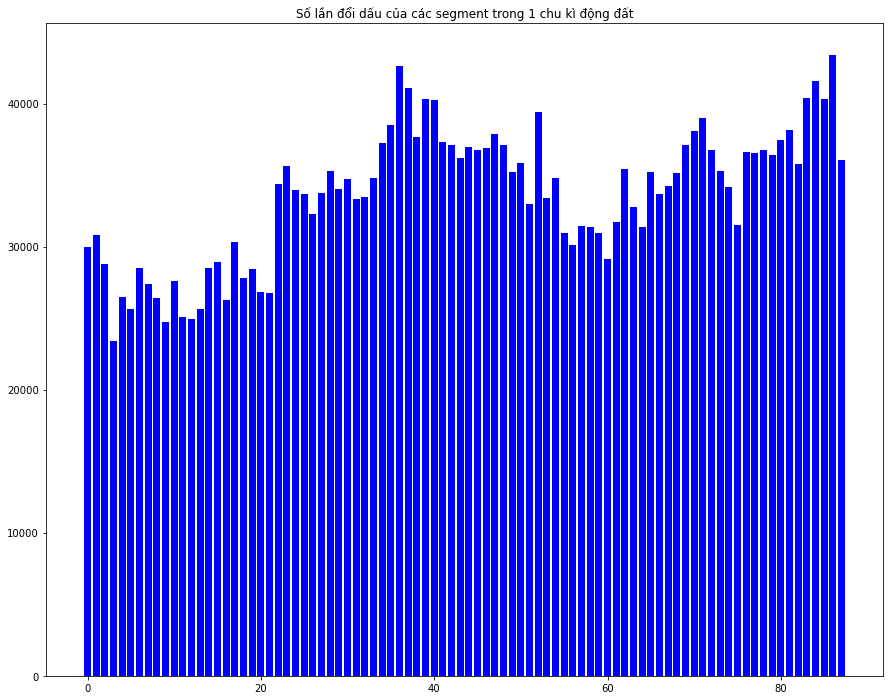

In [28]:
ZOR = get_ZOR(train_one_period.acoustic_data.values)
fig, ax = plt.subplots(figsize=(15,12))
plt.bar(range(len(ZOR)),ZOR, color='blue')
plt.title("Số lần đổi dấu của các segment trong 1 chu kì động đất")
plt.show()

**Bình luận:** Khoảng 1/3 lương segment đầu, số lần đổi dấu nhỏ hơn 2/3 lượng segment còn lại 

#### 4.2.3.5 Độ nhọn  

**Ý tưởng:** Độ nhọn của tín hiệu cũng được sử dụng để phản ánh mức độ bất ổn tín hiệu. Độ đo được sử dụng là `kurtosis` được cung cấp sẵn  

In [29]:
def get_Kurtosis(input_signal, interval_length = 150000):
    Kur = []
    for segment in range (0, int(len(input_signal)/interval_length)):
        Kur.append(input_signal[segment*interval_length:(segment+1)*interval_length].kurtosis())
    return Kur

**Bình luận:** 
- Hàm `get_Kurtosis` thực hiện cộng việc:
    - Duyệt qua các segment 
    - Tính điểm kurtosis sử dụng thư viện có sẵn 
- Hàm `get_Kurtosis` trả về số lần tín hiệu đổi dấu qua 0

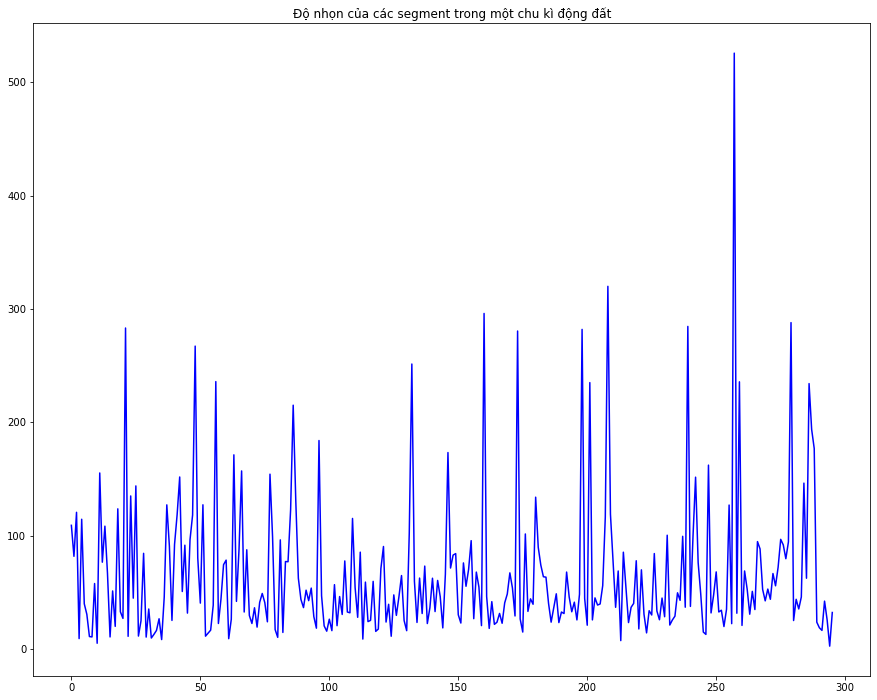

In [30]:
Kurtosis= get_Kurtosis(train_one_period['acoustic_data'])
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(Kurtosis, c="blue")
plt.title("Độ nhọn của các segment trong một chu kì động đất")
plt.show()

**Bình luận:** 
- Càng về cuối độ nhọn của dữ liệu càng lớn 
- **Tuy nhiên:** Độ nhọn của các segment dao động khác lớn nên cũng chỉ phục vụ cho trích chọn đăc trưng toàn cục. Nếu xử dụng trích chọn đặc trưng cục bộ thì sẽ không chính xác. 

#### 4.2.3.6 Khảo sát về mặt năng lược dùng Root-mean-square energy

**Ý tưởng:** Nhìn chung, các hiện tượng thiên nhiên đều xảy ra khi được kích hoạt bởi một nguồn năng lượng đủ mạnh. Lấy ý tưởng đó, em khảo sát chỉ số RMSE

In [31]:
def get_RMSE (input_signal, interval_length = 100000):    
    RMSE = []
    
    e = pd.DataFrame(input_signal * input_signal)
    for segment in range (0, int(len(input_signal)/interval_length)):
        RMSE.append(np.sqrt(e[segment*interval_length:(segment+1)*interval_length].sum()/interval_length))
    return RMSE

**Bình luận:** 
- Hàm `get_RMSE` thực hiện cộng việc:
    - Duyệt| qua các segment 
    - Tính điểm độ đo RMSE theo công thức 
- Hàm `get_RMSE` trả về năng lượng của từng segment trong data đó 

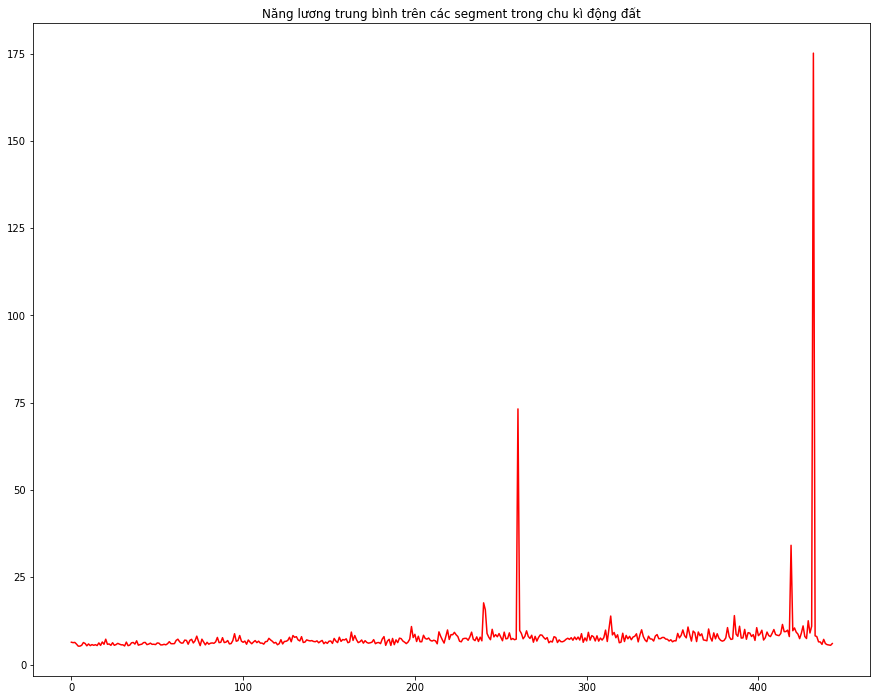

In [32]:
RMSE= get_RMSE(train_one_period['acoustic_data'])
fig, ax = plt.subplots(figsize=(15,12))
plt.plot(RMSE, c="red")
plt.title("Năng lương trung bình trên các segment trong chu kì động đất")
plt.show()

**Bình luận:** Theo chiều từ trái qua phải tương ứng với thời gian xảy ra động đất rút ngắn dần. Chỉ số RMSE của từng segment có xu hướng tăng dần và giao động bất ổn đinh hơn 

#### 4.2.3.7 Khảo sát trong miền tần số

**Ý tưởng:** Miền tần số có thể mang đến những đặc điểm mới của dữ liệu 
**Công việc:** Chuyển dữ liệu qua FFT rồi trực quan hóa 

  0%|          | 0/10 [00:00<?, ?it/s]

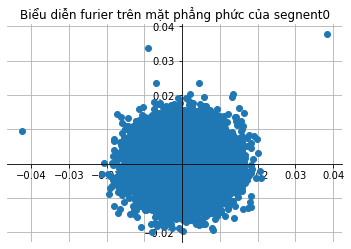

 10%|█         | 1/10 [00:03<00:34,  3.87s/it]

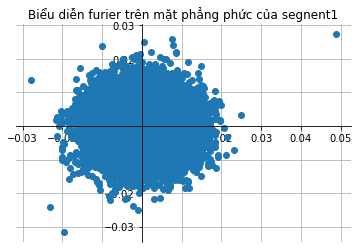

 20%|██        | 2/10 [00:07<00:31,  3.88s/it]

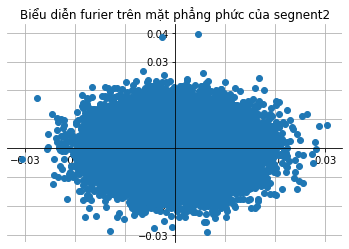

 30%|███       | 3/10 [00:11<00:27,  3.92s/it]

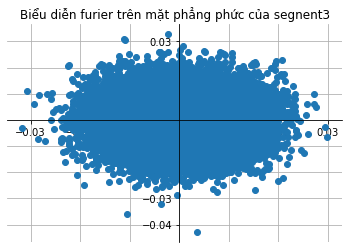

 40%|████      | 4/10 [00:15<00:23,  3.95s/it]

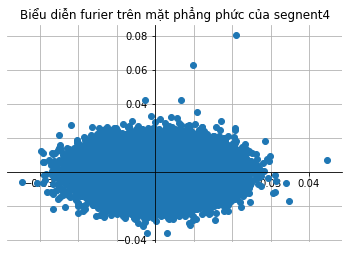

 50%|█████     | 5/10 [00:19<00:19,  3.95s/it]

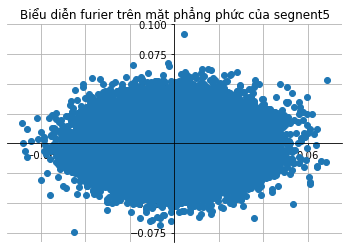

 60%|██████    | 6/10 [00:23<00:16,  4.01s/it]

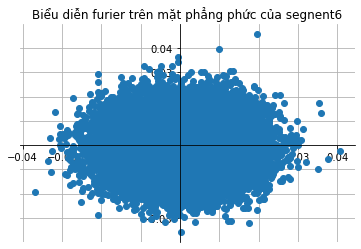

 70%|███████   | 7/10 [00:27<00:12,  4.06s/it]

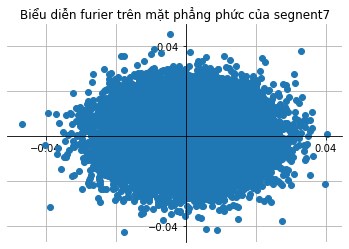

 80%|████████  | 8/10 [00:32<00:08,  4.06s/it]

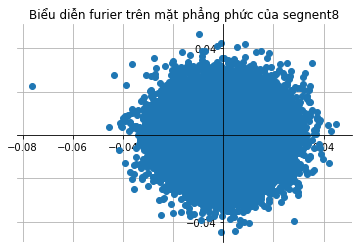

 90%|█████████ | 9/10 [00:36<00:04,  4.07s/it]

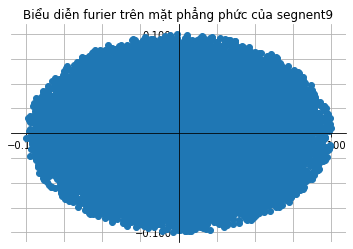

100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


In [63]:
rows = 4400000
segments = int(len(train_one_period)/rows)


for segment in tqdm(range(segments)):
    train_samples = train_one_period.acoustic_data.values[segment*rows : (segment+1)*rows]
    
    realFFT, imagFFT, _ = denoise_for_fft(train_samples, 0.1) 
            
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax1.grid(True, which='both')
    ax1.spines['left'].set_position('zero')
    ax1.spines['right'].set_color('none')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['top'].set_color('none')    
    ax1.plot(realFFT, imagFFT, 'o')
    ax1.set_title('Biểu diễn furier trên mặt phẳng phức của segnent' + str(segment))
    
    plt.show()

**Bình luận** Theo chiều từ trên xuống dưới tương ứng với thời gian xảy ra động đất rút ngắn dần:
- Các điểm biểu diễn của tần số trên trục phức ngày càng phình to hơn.
- Đặc biệt tại segment cuối cùng khi động đất sắp xảy ra, mật độ các điểm dày đặc và phân bố kín hình tròn có bán kính 0.1

# 5 Trích chọn đặc trưng 

**Vấn đề:** Để huấn luyện mô hình học máy cần trích chọn các đặc trưng cần thiết.  

**Công việc:** 

- Mỗi file test có 150000 tín hiệu. Vì vậy,em dùng hàm for để đọc, mỗi lần đọc lấy ra 150000 dữ liệu từ tập train rồi tiến hành trích chọn đặc trưng ngay sau đó.  
- 3 chiến lược trích chọn đặc trưng lần lượt là: Trích chọn đặc trưng toàn bộ, trích chọn đăc trưng phần cuối của segment và trích chọn đặc trưng cửa sổ trượt. Ý tưởng của từng chiến lược được trình bày trong từng phần cụ thể.
- Có hai miền dữ liệu được sử dụng là miền thời gian và miền tần số

## 5.1 Trích chọn đặc trưng toàn bộ 

**Ý tưởng:** Trích chọn đặc trưng toàn bộ cho cái nhìn chung nhất của đặc trưng về toàn bộ tín hiệu trong từ segment. 

### 5.1.1 Miền thời gian 

In [182]:
def get_time_domain_global_features(stt, data):
    input_np = data.values.reshape(len(data)) 
    global X
    
    X.loc[stt, 'tavg'] = data.mean()[0]
    X.loc[stt, 'tstd'] = data.std()[0]
    X.loc[stt, 'tmax'] = data.max()[0]
    X.loc[stt, 'tmin'] = data.min()[0]
    X.loc[stt, 'tq25'] = np.quantile(x, 0.25)
    X.loc[stt, 'tq50'] = np.quantile(x, 0.50)
    X.loc[stt, 'tq75'] = np.quantile(x, 0.75)
    X.loc[stt, 'tq90'] = np.quantile(x, 0.95)
    
    X.loc[stt, 'max_to_min'] = data.max()[0] / np.abs(data.min()[0])
    X.loc[stt, 'max_to_min_diff'] = x.max()[0] - np.abs(x.min()[0])
    
    X.loc[stt, 'tabs_avg'] = np.abs(data).mean()[0]
    X.loc[stt, 'tabs_std'] = np.abs(data).std()[0]
    X.loc[stt, 'tabs_max'] = np.abs(data).max()[0]
    X.loc[stt, 'tabs_min'] = np.abs(data).min()[0]
    X.loc[stt, 'tabs_q25'] = np.quantile(np.abs(x), 0.25)
    X.loc[stt, 'tabs_q50'] = np.quantile(np.abs(x), 0.50)
    X.loc[stt, 'tabs_q75'] = np.quantile(np.abs(x), 0.75)
    X.loc[stt, 'tabs_q90'] = np.quantile(np.abs(x), 0.95)
    
    X.loc[stt, 'num_signal_unchange'] = get_number_signal_unchange(input_np, len(input_np))[0]
    
    X.loc[stt, 'kurt'] = x.kurtosis()[0]

**Bình luận:** 
- Hàm `get_time_domain_global_features` thực hiện trích chọn các đặc trưng sau trên toàn bộ dữ liệu 
    - Cho cái nhìn tổng qua về ngưỡng: Giá trị trung bình, giá trị lớn nhất, giá trị nhỏ nhất, chênh lệch giữa giá trị lớn nhất và nhỏ nhất  
    - Mô tả rõ hơn phân bố của tín hiệu: Độ lệch chuẩn, bách phân vị 25%, 50%, 75%, 90%  
    - Ngoài ra các giá trị trên cũng được trích chọn trong miền trị tuyệt đối 
    - Số lượng điểm dữ liệu không thay đổi trong hai thời điểm liên tiếp được sử dụng theo **Phân tích và bình luận ở 4**. Hàm `get_number_signal_unchange` do em **code** ở **phần 4**
    - ĐỘ nhọn được sử dụng theo **Phân tích và bình luận ở 4**. Hàm `kurtosis` do em **code** ở **phần 4**

### 5.1.2 Miền tần số 

In [181]:
def get_FFT_global_features(stt, realFFT, imagFFT, magFFT):
    global X
    
    X.loc[stt, 'FFT_Ravg'] = realFFT.mean()
    X.loc[stt, 'FFT_Rstd'] = realFFT.std()
    X.loc[stt, 'FFT_Rmax'] = realFFT.max()
    X.loc[stt, 'FFT_Rmin'] = realFFT.min()
    X.loc[stt, 'FFT_Rq25'] = np.quantile(realFFT, 0.25)
    X.loc[stt, 'FFT_Rq50'] = np.quantile(realFFT, 0.50)
    X.loc[stt, 'FFT_Rq75'] = np.quantile(realFFT, 0.75)
    X.loc[stt, 'FFT_Rq90'] = np.quantile(realFFT, 0.95)
    
    X.loc[stt, 'FFT_Iavg'] = imagFFT.mean()
    X.loc[stt, 'FFT_Istd'] = imagFFT.std()
    X.loc[stt, 'FFT_Imax'] = imagFFT.max()
    X.loc[stt, 'FFT_Imin'] = imagFFT.min()
    X.loc[stt, 'FFT_Iq25'] = np.quantile(imagFFT, 0.25)
    X.loc[stt, 'FFT_Iq50'] = np.quantile(imagFFT, 0.50)
    X.loc[stt, 'FFT_Iq75'] = np.quantile(imagFFT, 0.75)
    X.loc[stt, 'FFT_Iq90'] = np.quantile(imagFFT, 0.95)
    
    X.loc[stt, 'FFT_Mavg'] = magFFT.mean()
    X.loc[stt, 'FFT_Mstd'] = magFFT.std()
    X.loc[stt, 'FFT_Mmax'] = magFFT.max()
    X.loc[stt, 'FFT_Mmin'] = magFFT.min()
    X.loc[stt, 'FFT_Mq25'] = np.quantile(magFFT, 0.25)
    X.loc[stt, 'FFT_Mq50'] = np.quantile(magFFT, 0.50)
    X.loc[stt, 'FFT_Mq75'] = np.quantile(magFFT, 0.75)
    X.loc[stt, 'FFT_Mq90'] = np.quantile(magFFT, 0.95)

**Bình luận:** 
* Hàm `get_FFT_global_features` thực hiện trích chọn các đặc trưng trong miền tuần suất trên toàn bộ dữ liệu với các đặc trưng là: **Phần thực**, **Phần ảo**, **Độ lớn**
* Các đặc trưng được mô tả qua các chỉ số: giá trị lớn nhất, giá trị nhỏ nhất, giá trị trung bình, độ lệch chuẩn và bách hợp 25%, 50%, 75%, 90% với mục đích mô tả ngưỡng, sự phân bố của tần số tín hiệu trên mặt phẳng phức. 

## 5.2 Trích chọn đặc trưng phần cuối của segment

**Ý tưởng:** Như đã phân tích ở trên, khi động đất sắp xảy ra, sẽ có một thời điểm trước đó, biên độ của tín hiệu sẽ tăng đột biến, đồng thời nhìn chung, độ lớn biên độ, năng lương, số lần đổi dấu cũng tăng. Do đó việc quan sát đặc trưng phần cuối của segment có thể giúp dự đoán động đất chính xác hơn.

### 5.2.1 Miền thời gian

In [180]:
def get_time_domain_last_features(stt, data):
    input_np = data.values.reshape(len(data))
    global X
    
    X.loc[stt, 'tstd_last_50000'] = data[-50000:].std()[0]
    X.loc[stt, 'tavg_last_50000'] = data[-50000:].mean()[0]
    X.loc[stt, 'tmin_last_50000'] = data[-50000:].min()[0]
    X.loc[stt, 'tmax_last_50000'] = data[-50000:].max()[0]
    
    X.loc[stt, 'tavg_last_10000'] = data[-10000:].mean()[0]
    X.loc[stt, 'tmin_last_10000'] = data[-10000:].min()[0]
    X.loc[stt, 'tmax_last_10000'] = data[-10000:].max()[0]
    X.loc[stt, 'tstd_last_10000'] = data[-10000:].std()[0]
    
    X.loc[stt, 'num_signal_unchange_last_50000'] = get_number_signal_unchange(input_np[-50000:], len(input_np[-50000:]))[0]
    X.loc[stt, 'num_signal_unchange_last_10000'] = get_number_signal_unchange(input_np[-10000:], len(input_np[-10000:]))[0]
    
    X.loc[stt, 'kurt_last_50000'] = x[-50000:].kurtosis()[0]
    X.loc[stt, 'kurt_last_10000'] = x[-10000:].kurtosis()[0]

**Bình luận:** 
- Hàm `get_time_domain_last_features` thực hiện trích chọn các đặc trưng trên lần lượng 50000 và 10000 điểm dữ liệu cuối cùng. 
- Các đặc trưng được trích chọn tương tự như trích chọn đặc trưng toàn cục trong miền thời gian trên toàn bộ dữ liệu. 

### Miền tần số 

In [234]:
def get_FFT_last_features(stt, magFFT):
    global X
    X.loc[stt, 'FFT_Mavg_last_10000'] = magFFT[-10000:].mean()
    X.loc[stt, 'FFT_Mstd__last_10000'] = magFFT[-10000:].std()
    X.loc[stt, 'FFT_Mmax_last_10000'] = magFFT[-10000:].max()
    X.loc[stt, 'FFT_Mmin_last_10000'] = magFFT[-10000:].min()
    
    X.loc[stt, 'FFT_Mavg_last_50000'] = magFFT[-50000:].mean()
    X.loc[stt, 'FFT_Mstd_last_50000'] = magFFT[-50000:].std()
    X.loc[stt, 'FFT_Mmax_last_50000'] = magFFT[-50000:].max()
    X.loc[stt, 'FFT_Mmin_last_50000'] = magFFT[-50000:].min()

**Bình luận:** 
- Hàm `get_FFT_last_features` thực hiện trích chọn các đặc trưng trên lần lượng 50000 và 10000 điểm dữ liệu cuối cùng. 
- Các đặc trưng được trích chọn tương tự như trích chọn đặc trưng toàn cục trong miền tần số trên toàn bộ dữ liệu. 

## 5.3 Trích chọn đặc trưng của sổ trượt 

**Vấn đề:** 
- Trích chọn đặc trưng toàn cục có nhược điểm là không mô tả được đủ sự biến đổi và phân bố của dữ liệu trong segment đó. 
- Một số đặc trưng như độ bao phủ của biên độ hay Root-mean-square energy đòi hỏi phải chia segment hiện tại thành cách segment nhỏ hơn rồi dùng cửa sổ trượt để tính toán. 
 
**Giải quyết:** 
 - **Bước 1: Tính toán đặc trưng:** Em sẽ sử dụng cửa số cuộn để trượt trên dữ liệu rồi lấy ra đặc trưng của từng subsegment.
 - **Bước 2: Tổng hợp đặc trưng:** Dùng các chỉ số thống kê để mô tả đặc điểm của đặc trưng đó 

### 5.3.1 Miền thời gian 

In [285]:
def get_time_domain_rolling(stt, data, windows):
    input_np = data.values.reshape(len(data))  
                                   
    x_roll_std = data.rolling(windows).std().dropna()
    x_roll_mean = data.rolling(windows).mean().dropna()

    X.loc[stt, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()[0]
    X.loc[stt, 'std_roll_std_' + str(windows)] = x_roll_std.std()[0]
    X.loc[stt, 'max_roll_std_' + str(windows)] = x_roll_std.max()[0]
    X.loc[stt, 'min_roll_std_' + str(windows)] = x_roll_std.min()[0]
    
    X.loc[stt, 'q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
    X.loc[stt, 'q50_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.50)
    X.loc[stt, 'q75_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.75)
    X.loc[stt, 'q90_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.90)

    X.loc[stt, 'q25_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.25)
    X.loc[stt, 'q50_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.50)
    X.loc[stt, 'q75_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.75)
    X.loc[stt, 'q90_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.90)
    
    x_ae_pos, _ = get_envelope(data, windows)
    x_ae = np.array(x_ae_pos)
    X.loc[stt, 'ave_ae_' + str(windows)] = x_ae.mean()
    X.loc[stt, 'std_ae_' + str(windows)] = x_ae.std()
    X.loc[stt, 'min_ae_' + str(windows)] = x_ae.min()
    
    X.loc[stt, 'q25_ae_' + str(windows)] = np.quantile(x_ae, 0.25)
    X.loc[stt, 'q50_ae_' + str(windows)] = np.quantile(x_ae, 0.50)
    X.loc[stt, 'q75_ae_' + str(windows)] = np.quantile(x_ae, 0.75)
    X.loc[stt, 'q90_ae_' + str(windows)] = np.quantile(x_ae, 0.90)
    
    x_rmse = np.array(get_RMSE(data, windows))
    X.loc[stt, 'ave_rmse_' + str(windows)] = x_rmse.mean()
    X.loc[stt, 'std_rmse_' + str(windows)] = x_rmse.std()
    X.loc[stt, 'max_rmse_' + str(windows)] = x_rmse.max()
    X.loc[stt, 'min_rmse_' + str(windows)] = x_rmse.min()
    
    X.loc[stt, 'q25_rmse_' + str(windows)] = np.quantile(x_rmse, 0.25)
    X.loc[stt, 'q50_rmse_' + str(windows)] = np.quantile(x_rmse, 0.50)
    X.loc[stt, 'q75_rmse_' + str(windows)] = np.quantile(x_rmse, 0.75)
    X.loc[stt, 'q90_rmse_' + str(windows)] = np.quantile(x_rmse, 0.90)
    
    x_zor = np.array(get_ZOR(input_np, windows))
    X.loc[stt, 'ave_zor_' + str(windows)] = x_zor.mean()
    X.loc[stt, 'std_zor_' + str(windows)] = x_zor.std()
    X.loc[stt, 'max_zor_' + str(windows)] = x_zor.max()
    X.loc[stt, 'min_zor_' + str(windows)] = x_zor.min()
       
    X.loc[stt, 'q25_zor_' + str(windows)] = np.quantile(x_zor, 0.25)
    X.loc[stt, 'q50_zor_' + str(windows)] = np.quantile(x_zor, 0.50)
    X.loc[stt, 'q75_zor_' + str(windows)] = np.quantile(x_zor, 0.75)
    X.loc[stt, 'q90_zor_' + str(windows)] = np.quantile(x_zor, 0.90)

**Bình luận:** 
- Hàm `get_time_domain_rolling` thực hiện trích chọn các đặc trưng sử dụng cửa sổ cuộn:
     - **Bước 1: Tính toán đặc trưng:** Em sẽ sử dụng cửa số cuộn để trượt trên dữ liệu rồi lấy ra đặc trưng của từng subsegment.
     - **Bước 2: Tổng hợp đặc trưng:** Dùng các chỉ số thống kê để mô tả đặc điểm của đặc trưng đó 
- Các đặc trưng là:
    - Độ lệch chuẩn, giá trị trung bình của từng subsegment
    - Độ bao phủ biên độ được sử dụng theo **Phân tích và bình luận ở 4**. Hàm `get_envelope` được **code** ở **phần 4**
    - Chỉ số năng lương RMSE được sử dụng theo **Phân tích và bình luận ở 4**. Hàm `get_RMSE` được **code** ở **phần 4**
    - Số lượng tính hiệu đi qua 0 của từng subsegment sử dụng theo **Phân tích và bình luận ở 4**. Hàm `get_ZOR` được **code** ở **phần 4**

### 5.3.2 Miền tần số 

In [267]:
def get_FFT_rolling(stt, magFFT, windows):
    global X
    x_roll_std = magFFT.rolling(windows).std().dropna().values
    x_roll_mean = magFFT.rolling(windows).mean().dropna().values
        
    X.loc[stt, 'FFT_avg_roll_std_' + str(windows)] = x_roll_std.mean()
    X.loc[stt, 'FFT_std_roll_std_' + str(windows)] = x_roll_std.std()
    X.loc[stt, 'FFT_max_roll_std_' + str(windows)] = x_roll_std.max()
    X.loc[stt, 'FFT_min_roll_std_' + str(windows)] = x_roll_std.min()
    
    X.loc[stt, 'FFT_q25_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.25)
    X.loc[stt, 'FFT_q50_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.50)
    X.loc[stt, 'FFT_q75_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.75)
    X.loc[stt, 'FFT_q90_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.90)

    X.loc[stt, 'FFT_q25_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.25)
    X.loc[stt, 'FFT_q50_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.50)
    X.loc[stt, 'FFT_q75_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.75)
    X.loc[stt, 'FFT_q90_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.90)

**Bình luận:** 
- Hàm `get_FFT_rolling` có các đặc trưng được trích chọn tương tự như trích chọn đặc trưng toàn cục trong miền tần số trên toàn bộ dữ liệu. 

## 5.4 Tiến hành trích chọn đặc trưng  

Như đã mô tả ở phần đầu, do tập test chia thành các segment có độ dài 150000. Nên em sẽ trích chọn đặc trưng cho từng segment một ở tập train tương tự. Mỗi segment có độ dài 150000 điểm dữ liệu.   
**Vấn đề:** Việc load toàn bộ 9GB dữ liệu train vào là không khả thi. Việc load từng segment vào một cũng không khả thi, mất hơn 8 tiếng đồng hồ do việc đọc file mất nhiều thời gian.   
**Giải pháp:** Với dữ liệu tín hiệu 
- **Bước 1:** Chia tập train thành 100 phần (parts). Load lần lượt từng phần từ ổ cứng vào 
- **Bước 2:** Lấy từng segment từ các phần (mỗi phần có 10 segment) rồi trích chọn đặc trưng cho từng segment
- **Bước 3:** Lưu đặc trưng của các segment trong từng phần vào file `data/train_feature/part_{part_id}` để sử dụng sau này

**Giải pháp:** Với dữ liệu thời gian ta áp dụng **Bước 1** và **Bước 2** tương tự nhưng không thực hiện **Bước 3**

In [300]:
rows = 150000
segments = int(600000000/rows) 
parts = 100

In [294]:
for part in range(0,int(segments/parts)):
    part_start = part*parts + 1
    part_end = (part+1)*parts + 1 
    data_parts = pd.read_csv('data/train.csv', nrows = rows*parts, skiprows=part_start*rows+1)
    data_parts_x = data_parts.iloc[:,[0]].values.reshape(len(data_parts))
    
    X= pd.DataFrame(index=range(parts), dtype=np.float64)
    for segment in tqdm(range(part_start, part_end)):  
        start = (segment-part_start)*rows
        end = (segment-part_start+1)*rows
        data_x = data_parts_x[start:end]
        x = pd.DataFrame(denoise_for_signal(data_x, 0.1))

        stt = segment%parts

        get_time_domain_global_features(stt, x)
        get_time_domain_last_features(stt,x)

        realFFT, imagFFT, magFFT = denoise_for_fft(x, 0.1, denoise=False)
        get_FFT_global_features(stt,realFFT, imagFFT, magFFT)

        get_FFT_last_features(stt,magFFT)

        for windows in [100, 1000]:
            get_time_domain_rolling(stt,x, windows)
            get_FFT_rolling(stt, pd.DataFrame(magFFT), windows)


        if (segment % parts == 0):
            X.to_csv("data/train_feature/part_" + str(int(segment/parts)) + ".csv")
            del X
            X= pd.DataFrame(index=range(parts), dtype=np.float64)

100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


# 6 Modeling

## 6.1 Đọc dữ liệu 
- Dữ liệu thời gian Y được đọc trực tiếp từ file data gốc  
- Dữ liệu đặc trưng của tín hiệu được load từ các file đặc trưng được lưu trước ddo

In [605]:
Y= pd.DataFrame(index=range(segments), dtype=np.float64,columns=['time_to_failure'])

In [606]:
for part in tqdm(range(0,int(segments/parts))):
    part_start = part*parts + 1
    part_end = (part+1)*parts + 1 
    data_parts = pd.read_csv('data/train.csv', nrows = rows*parts, skiprows=part_start*rows+1)
    data_parts_y = data_parts.iloc[:,[1]].values
    
    for segment in range(part_start, part_end):  
        start = (segment-part_start)*rows
        end = (segment-part_start+1)*rows
        data_y = data_parts_x[start:end]
        y = data_y[-1]
        Y.loc[segment-1, 'time_to_failure'] = y

100%|██████████| 40/40 [14:49<00:00, 22.25s/it]


In [608]:
X= pd.DataFrame(index=range(segments), dtype=np.float64)

In [609]:
part_datas = []
for index in tqdm(range(1,41)):
    url = 'data/train_feature/part_{}.csv'.format(index)
    part_datas.append(pd.read_csv(url))
    
X = pd.concat(part_data, ignore_index=True)
X.drop(part_data_1.columns[[0]], axis=1, inplace=True)
X

100%|██████████| 40/40 [00:00<00:00, 77.42it/s]


,tavg,tstd,tmax,tmin,tq25,tq50,tq75,tq90,tabs_avg,tabs_std,...,FFT_max_roll_std_1000,FFT_min_roll_std_1000,FFT_q25_roll_std_1000,FFT_q50_roll_std_1000,FFT_q75_roll_std_1000,FFT_q90_roll_std_1000,FFT_q25_roll_mean_1000,FFT_q50_roll_mean_1000,FFT_q75_roll_mean_1000,FFT_q90_roll_mean_1000
0,5.763648e-05,4.653887,106.668240,-105.576487,-2.082007,0.053319,2.164562,5.514622,2.878327,3.657027,...,0.000104,0.000010,0.000011,0.000012,0.000014,0.000022,0.000015,0.000016,0.000018,0.000025
1,7.146927e-05,5.902161,174.632223,-153.797077,-2.642731,-0.001547,2.662209,7.058242,3.607436,4.671384,...,0.000179,0.000011,0.000014,0.000015,0.000020,0.000030,0.000018,0.000020,0.000024,0.000033
2,6.603165e-05,6.185809,113.967762,-94.121841,-2.875236,-0.020875,2.847331,7.911789,3.970112,4.743663,...,0.000134,0.000012,0.000015,0.000016,0.000022,0.000039,0.000019,0.000021,0.000027,0.000042
3,-6.623912e-07,5.936826,139.850700,-136.343584,-2.711434,-0.000759,2.707106,7.320654,3.714183,4.631486,...,0.000167,0.000011,0.000014,0.000015,0.000020,0.000029,0.000018,0.000020,0.000025,0.000033
4,7.271734e-05,6.643147,114.974875,-109.296209,-2.806010,-0.006619,2.783140,7.743074,3.979779,5.319084,...,0.000158,0.000012,0.000014,0.000016,0.000020,0.000035,0.000018,0.000020,0.000026,0.000037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,7.193362e-05,5.169831,109.396590,-95.523424,-2.377719,-0.011409,2.370459,6.323229,3.230201,4.036445,...,0.000142,0.000011,0.000012,0.000013,0.000016,0.000027,0.000016,0.000018,0.000021,0.000030
3996,4.111039e-05,4.670989,135.774115,-141.072915,-2.177757,-0.013929,2.161666,5.748625,2.916802,3.648334,...,0.000152,0.000010,0.000011,0.000012,0.000015,0.000024,0.000015,0.000016,0.000019,0.000026
3997,7.350809e-05,4.795053,117.668915,-158.769275,-2.211525,-0.004808,2.227039,6.009861,3.021074,3.723652,...,0.000149,0.000010,0.000011,0.000013,0.000017,0.000027,0.000015,0.000016,0.000021,0.000030
3998,7.960472e-05,5.242458,97.714618,-103.170873,-2.306761,0.004568,2.303761,6.186534,3.186431,4.162926,...,0.000135,0.000010,0.000012,0.000013,0.000017,0.000025,0.000016,0.000017,0.000021,0.000028


## 6.2 Chuẩn hóa dữ liệu 

**Vấn đề:** Các dữ liệu đặc trưng chưa được chuẩn hóa sẽ có độ lớn và phân bố khác nhau. Khi có một thuộc tính trong dữ liệu lớn hơn các thuộc tính khác rất nhiều, mô hình sẽ phụ thuộc vào thuộc tính này rất nhiều. Để có được kết quả chính xác hơn, ta cần chuẩn hóa dữ liệu.  
**Giải quyết** Chuẩn hóa dữ liệu về trung bình = 0, độ lệch chuẩn = 1

In [610]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(X) 
X = scaler.transform(X)

In [611]:
Y = Y.values.reshape((1,len(Y.values)))[0]

In [612]:
X.shape

(4000, 158)

## 6.3  Modeling 

Chia dữ liệu thành 2 tập validation và train để đánh giá mô hình 

In [684]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Việc lưu kết quả của mô hình nhằm so sánh độ chính xác và đánh giá 

In [783]:
result = pd.DataFrame()
result['actually'] = y_test

### 6.3.1 Mô hình KNN

**Ý tưởng:** Dự đoán y của x bằng cách dựa vào trung bình của tông trọng số của các các điểm lân cận của x theo công thức sau. 

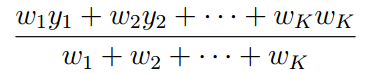

In [686]:
display.Image("./image/KNN.png")

In [705]:
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsRegressor as KNN

In [706]:
params = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform', 'distance'],
}

gridKNN = GridSearchCV(KNN(), params, scoring='neg_mean_absolute_error')

gridKNN.fit(X_train, y_train)
print(gridKNN.best_params_)

{'n_neighbors': 7, 'weights': 'uniform'}


**Bình luận** Việc sử dụng `GridSearchCV` nhằm tìm tham số tối ưu nhất cho mô hình với hai tham số là 
- `n_neighbors` là số hàng xóm được xét đến 
- `weights` là trọng số của từng hàng xóm với uniform là trọng số bình đẳng, distance là trọng số dựa vào khoảng cách 

In [784]:
y_predict_knn = gridKNN.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict_knn)
result['knn'] = y_predict_knn
print(mae)

2.8213203463203467


**Phân tích lỗi:** 
- Kết quả của KNN thấp nhất có thể do mô hình vẫn còn tồn tại nhiễu. KNN rất nhạy cảm với nhiễu nên gây ra kết quả không tốt
- Việc dùng KNN có thể không phù hợp với dữ liệu biến động. 

### 6.3.2 Mô hình hồi quy tuyến tính 

**Ý tưởng:** Tìm một siêu phẳng sao cho tối thiểu hóa giá trị của hàm loss function hay có cách gọi khác là bình phương tối thiểu 

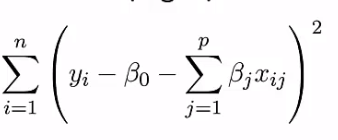

In [697]:
display.Image("./image/Linear.png")

In [698]:
from sklearn.linear_model import LinearRegression

In [785]:
LinearModel = LinearRegression().fit(X_train, y_train)
y_predict_linear = LinearModel.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict_linear)
result['linear'] = y_predict_linear
print(mae)

2.6805472307528992


**Phân tích lỗi:** 
- Mô hình là mặt siêu phẳng nên có thể chưa đủ mềm mại với dữ liệu 
- Mô hình tuyết tính nhạy cảm với nhiễu 

### 6.3.3 Mô hình kết hợp xgboost

**Vấn đề** Các mô hình học máy thì đều có những ưu nhược điểm riêng, do đó có thể mang lại kết quả tốt trên phần này của dữ liệu nhưng lại cho ra kết quả không tốt ở phần còn lại 

**Giải pháp:** Kết hợp nhiều mô hình học máy giống hoặc khác nhau và tổng hợp kết quả dự đoán của chúng để nâng cao tính tổng quát hóa. Phương pháp thứ hai được gọi là Ensemble Learning. 

**xgboost** là một trong những mô hình kết hơp được sử dụng nhiều trong các cuộc thi của kaggle:
- **xgboost** là một mô hình loại boosting. Các model sẽ được train lần lượt nhau nhằm học cách sửa những errors của model trước
- **xgboost** dựa trên gradient boosting 
- **xgboost** dùng base model là cây quyết định 

In [733]:
import xgboost as xgb 

In [734]:
params = {'max_depth': [3, 5, 10],
          'eta': [0.1, 0.3, 0.5],
          'max_depth': [1, 3, 5, 7, 9, 11],
          'eval_metric': ['mae']}

gridXGB = GridSearchCV(xgb.XGBRegressor(), params, scoring='neg_mean_absolute_error')

**Bình luận** Việc sử dụng `GridSearchCV` nhằm tìm tham số tối ưu nhất cho mô hình với hai tham số là 
- `max_depth` là độ sâu tối đa của cây 
- `eta` là learning rate
- `max_depth` là độ sâu tối đa của cây 
- `eval_metric` là hàm đánh giá sẽ sử dụng 

In [735]:
gridXGB.fit(X_train, y_train)
print(gridXGB.best_params_)

{'eta': 0.1, 'eval_metric': 'mae', 'max_depth': 1}


Dự đóa y và tính sai số

In [786]:
y_predict_XGB = gridXGB.predict(X_test) 
mae = mean_absolute_error(y_test, y_predict_XGB)
result['xgb'] = y_predict_XGB
print(mae)

2.6138164070519534


### 6.3.4 Mô hình mạng nơ ron 

**Ý tưởng:** mô hình hồi quy tuyến tính có nhược điểm là tạo ra mặt siêu phẳng có thể không đủ mềm dẻo với dữ liệu. Mô hình mạng nơ ron với tính chất phi tuyến có thể khắc phục điều này   
**Công việc** Tạo mạng nơ ron đầy đủ với 5 layer được mô tả bên dưới 

In [754]:
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [755]:
def Model(input_dim, learning_rate=0.001):
    model = Sequential()

    model.add(Dense(64, activation = 'tanh', input_dim = input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation = 'tanh')) 
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation = 'tanh'))    
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(8, activation = 'tanh'))    
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(1))    
    model.compile(loss = 'mean_absolute_error', optimizer = Adam(learning_rate), metrics = ['mean_absolute_error'])
    model.summary()
    
    return model

In [773]:
model = Model(input_dim = X_train.shape[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 64)                10176     
_________________________________________________________________
batch_normalization_47 (Batc (None, 64)                256       
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_48 (Batc (None, 32)                128       
_________________________________________________________________
dropout_48 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 64)              

In [774]:
deepModel = model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
84/84 [==============================] - 1s 2ms/step - loss: 4.6223 - mean_absolute_error: 4.6223
Epoch 2/100
84/84 [==============================] - 0s 2ms/step - loss: 4.2445 - mean_absolute_error: 4.2445
Epoch 3/100
84/84 [==============================] - 0s 2ms/step - loss: 3.9294 - mean_absolute_error: 3.9294
Epoch 4/100
84/84 [==============================] - 0s 2ms/step - loss: 3.6852 - mean_absolute_error: 3.6852
Epoch 5/100
84/84 [==============================] - 0s 2ms/step - loss: 3.3759 - mean_absolute_error: 3.3759
Epoch 6/100
84/84 [==============================] - 0s 2ms/step - loss: 3.1746 - mean_absolute_error: 3.1746
Epoch 7/100
84/84 [==============================] - 0s 2ms/step - loss: 2.9907 - mean_absolute_error: 2.9907
Epoch 8/100
84/84 [==============================] - 0s 2ms/step - loss: 2.9027 - mean_absolute_error: 2.9027
Epoch 9/100
84/84 [==============================] - 0s 2ms/step - loss: 2.9122 - mean_absolute_error: 2.9122
Epoch 10/1

84/84 [==============================] - 0s 2ms/step - loss: 2.6914 - mean_absolute_error: 2.6914
Epoch 75/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6973 - mean_absolute_error: 2.6973
Epoch 76/100
84/84 [==============================] - 0s 2ms/step - loss: 2.7055 - mean_absolute_error: 2.7055
Epoch 77/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6873 - mean_absolute_error: 2.6873
Epoch 78/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6937 - mean_absolute_error: 2.6937
Epoch 79/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6753 - mean_absolute_error: 2.6753
Epoch 80/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6907 - mean_absolute_error: 2.6907
Epoch 81/100
84/84 [==============================] - 0s 3ms/step - loss: 2.6549 - mean_absolute_error: 2.6549
Epoch 82/100
84/84 [==============================] - 0s 2ms/step - loss: 2.6710 - mean_absolute_error: 2.6710
Epoch 83/100
8

In [787]:
y_pred_deep = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_deep)
result['deep'] = y_pred_deep
print(mae)

2.601715178020073


**Phân tích lỗi** Kết quả có thể chưa chính xác vì có quá ít dữ liệu cho mạng nơ ron nên trưa thể train kĩ hơn 

### 4.3.5 Mô hình kết hợp 

**Ý tưởng:** Hai mô hình xgboost và mạng nơ ron cho hai kết quả tốt nhất. Em thử kết hợp hai mô hình này lại bằng cách lấy trung bình cộng kết quả dự đoán.

In [794]:
y_pred = (result['deep']+ result['xgb'])/2
mae = mean_absolute_error(y_test, y_pred)
print(mae)

2.5975008092143317


**Bình luận** Kết quả tốt hơn thể hiện hai mô hình này tương hỗ và bổ trợ cho nhau 

## 6.4 Save model

In [796]:
import pickle

In [798]:
filename = "saved models/KNNModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(gridKNN, file)

In [799]:
filename = "saved models/LinearModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(LinearModel, file)

In [800]:
filename = "saved models/XgBModel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(gridXGB, file)

In [801]:
model.save('saved models/DeepModel')

INFO:tensorflow:Assets written to: saved models/DeepModel/assets


# 7 Dự đoán tập test 

**Bước 1: Khởi tạo dataframe lưu trữ các test segment**  
Công việc: Khởi tạo dựa vào file sample_submission.csv

In [815]:
submission_exmaple = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
X= pd.DataFrame(dtype=np.float64, index=submission_exmaple.index)
X

""
seg_id
seg_00030f
seg_0012b5
seg_00184e
seg_003339
seg_0042cc
...
seg_ff4236
seg_ff7478
seg_ff79d9


**Bước 2: Load các file test tiến hành khử nhiễu, trích chọn đặc trưng**  

In [816]:
for i, segment in enumerate(tqdm(X.index)):
        url = 'data/test/{}.csv'.format(segment)
        seg = pd.read_csv(url)
        x = pd.DataFrame(seg['acoustic_data'].values)  

        get_time_domain_global_features(segment, x)
        get_time_domain_last_features(segment,x)

        realFFT, imagFFT, magFFT = denoise_for_fft(x, 0.1, denoise=False)
        get_FFT_global_features(segment,realFFT, imagFFT, magFFT)

        get_FFT_last_features(segment,magFFT)

        for windows in [100, 1000]:
            get_time_domain_rolling(segment,x, windows)
            get_FFT_rolling(segment, pd.DataFrame(magFFT), windows)

100%|██████████| 2624/2624 [1:55:07<00:00,  2.63s/it]


In [817]:
X

,tavg,tstd,tmax,tmin,tq25,tq50,tq75,tq90,tabs_avg,tabs_std,...,FFT_max_roll_std_1000,FFT_min_roll_std_1000,FFT_q25_roll_std_1000,FFT_q50_roll_std_1000,FFT_q75_roll_std_1000,FFT_q90_roll_std_1000,FFT_q25_roll_mean_1000,FFT_q50_roll_mean_1000,FFT_q75_roll_mean_1000,FFT_q90_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780,4.893690,115.0,-75.0,2.0,4.0,7.0,11.0,5.224607,4.102161,...,0.000122,0.000016,0.000018,0.000020,0.000024,0.000035,0.000031,0.000032,0.000035,0.000043
seg_0012b5,4.171153,5.922839,152.0,-140.0,2.0,4.0,7.0,11.0,5.198340,5.045369,...,0.000148,0.000016,0.000018,0.000019,0.000023,0.000036,0.000029,0.000030,0.000033,0.000043
seg_00184e,4.610260,6.946990,248.0,-193.0,2.0,5.0,7.0,11.0,5.597193,6.179525,...,0.000270,0.000016,0.000018,0.000019,0.000023,0.000035,0.000031,0.000033,0.000035,0.000044
seg_003339,4.531473,4.114147,85.0,-93.0,3.0,5.0,7.0,10.0,4.961487,3.583863,...,0.000111,0.000016,0.000017,0.000017,0.000019,0.000028,0.000030,0.000031,0.000033,0.000038
seg_0042cc,4.128340,5.797164,177.0,-147.0,2.0,4.0,6.0,10.0,5.070900,4.993617,...,0.000174,0.000016,0.000017,0.000018,0.000022,0.000035,0.000028,0.000030,0.000033,0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seg_ff4236,4.095773,5.082443,71.0,-50.0,2.0,4.0,6.0,11.0,5.040547,4.147218,...,0.000069,0.000015,0.000018,0.000019,0.000024,0.000040,0.000029,0.000030,0.000034,0.000045
seg_ff7478,4.138493,6.031596,164.0,-208.0,2.0,4.0,6.0,10.0,5.059093,5.283257,...,0.000222,0.000015,0.000017,0.000018,0.000022,0.000032,0.000029,0.000030,0.000032,0.000040
seg_ff79d9,3.748587,9.467532,310.0,-303.0,1.0,4.0,6.0,11.0,5.503880,8.566987,...,0.000428,0.000015,0.000018,0.000020,0.000028,0.000043,0.000027,0.000029,0.000035,0.000047


In [818]:
X.to_csv("data/test_feature.csv")

**Bước 3: Chuẩn hóa**

In [819]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(X) 
X = scaler.transform(X)

**Bước 4: Dự đoán**

Dùng mô hình xgboost

In [821]:
filename = "saved models/XgBModel.pkl"
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [822]:
y_predict_test_xgb = pickle_model.predict(X) 
y_predict_test_xgb

array([4.230271 , 4.365495 , 3.1917233, ..., 4.438889 , 4.5921783,
       4.0275617], dtype=float32)

In [823]:
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = y_predict_test_xgb

In [824]:
submission.to_csv('submissions/xgb_submissions')

Dùng mô hình mạng nơ ron 

In [826]:
y_predict_test_deep = model.predict(X) 
y_predict_test_deep

array([[5.0002766],
       [5.2632236],
       [4.1542053],
       ...,
       [3.8179562],
       [4.4352026],
       [4.19374  ]], dtype=float32)

In [827]:
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = y_predict_test_deep
submission.to_csv('submissions/deep_submissions')

Kết hợp hai mô hình 

In [828]:
y_predict_test_mix = (y_predict_test_deep+y_predict_test_xgb)/2

In [829]:
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = y_predict_test_mix
submission.to_csv('submissions/mix_submissions')

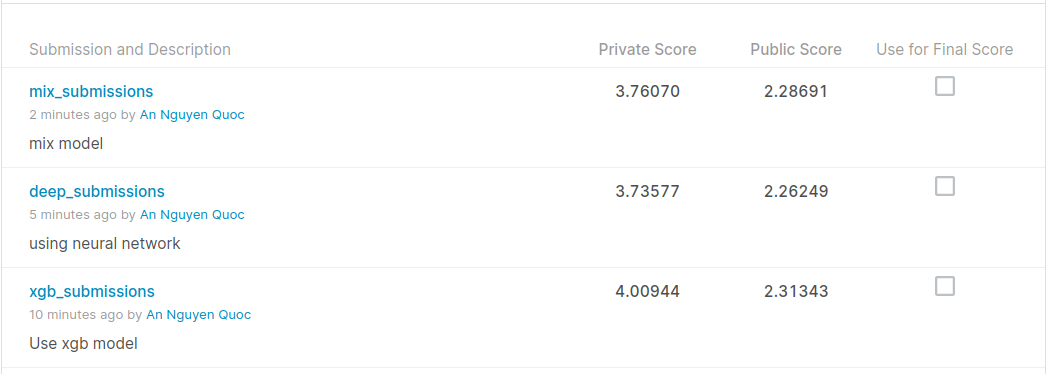

In [830]:
display.Image("./test_result.png")

**Bình luận:** 
- Kết quả mô hình mạng nơ ron cho kết quả cao nhất trên tập test. 
- Mô hình kết hợp mix tuy tốt hơn trên tập validation nhưng lại kém hơn trên tập test 

# 8 Kết luận 

**Điều em đã học hỏi được**
- Đây là lần đầu tiên em làm việc với dữ liệu timeseries, em đã tìm tòi và học hỏi được nhiều điều về trích chọn đặc trưng cho bài toán. Đồng thời, cố gắng tự code để hiểu các đặc trưng mà mình tìm hiểu được.
- Đây là một bài toán có dữ liệu raw lớn đối với em và máy tính cá nhân của em. Em đã được tìm hiểu và làm quen với các cách tải và xử lí dữ liệu từng phần sao cho hợp lí 
- Trong bài toán này, em cũng đã thực hành các mô hình, tìm hiểu và cố gắng phân tích lỗi của từng mô hình.

**Phân tích lỗi và công việc dự định**
- Số lượng đặc trưng trích chọn được còn chưa đủ nhiều. Em chưa phân tích được sự đóng góp của từng đặc trưng đã trích chọn trong mô hình vì thời gian trích chọn đặc trưng và chạy mô hình khá lâu. Trong tương lai, Em sẽ tìm hiểu và trích chọn thêm đặc trưng cho bài toán và phân tích tầm quan trọng của các đặc trưng trong từng mô hình cụ thể. 

- Số lượng các segment của tập train chưa đủ lớn có thể ảnh hưởng tới chất lượng của mô hình. Số lượng segment này được trượt lần lượt trên 600 triệu điểm dữ liệu trong thời gian là 8 tiếng đồng hồ. Trong tương lai, em sẽ tìm hiểu các phương pháp lấy thêm các segment, ví dụ như lấy random hoặc là trượt đè lên nhau.

- Trong tương lai, em cũng mong muốn tìm hiểu thêm các mô hình học sâu như RNN, LSTM, GRU... các mô hình không cần trích chọn đặc trưng và rất phù hợp với dữ liệu timeseries

**Cảm ơn thầy đã xem bài báo cáo của em và đã dạy em trong suốt một kì học vừa qua. Em chúc thầy luôn mạnh khỏe và công tác tốt ạ**